### Robustness Benchmark results

In [2]:
# surpress UserWarnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [4]:
import mmcv
def read_results_file(jobname, postfix="_results.pkl"):
    folder = "evaluation/benchmark/"
    if postfix == "_tpfp.pkl":
        folder += "tpfp/"
    path = folder + "rob-bm-full" + jobname
    res = mmcv.load(path + postfix)
    return res

In [ ]:
# get keys (corruptions) of result files
for job in ["-2_ff-baseline","_ff-baseline","-2_fb-add","_fb-add","_fb-mod"]:
    res = read_results_file(job)
    last_sevs = list(res.values())[-1].keys()
    print(f'{job}: {res.keys()} severities of last: {last_sevs} \n')

#### Merge the result dicts

In [5]:
def merge_dicts(names, postfix="_results.pkl"):
    dict_1 = read_results_file(names[0], postfix)
    dict_2 = read_results_file(names[1], postfix)
    dict_1.update(dict_2)
    # save to file
    folder = "evaluation/benchmark/merged/"
    path = folder + "rob-bm-merged_" + names[2] + postfix
    mmcv.dump(dict_1, path, file_format='pkl')
    print(f'merged dict: {names[2]}\n {dict_1.keys()} \n')
    return dict_1

In [ ]:
for names in [["-2_ff-baseline","-3_ff-baseline","ff-baseline"],
            ["-2_fb-add","-3_fb-add","fb-add"],
            ["_fb-mod","-3_fb-mod","fb-mod"]]:
    #merge_dicts(names, postfix="_results.pkl")
    merge_dicts(names, postfix='_tpfp.pkl')

merged dict: ff-baseline
 dict_keys(['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']) 

merged dict: fb-add
 dict_keys(['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']) 

merged dict: fb-mod
 dict_keys(['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']) 



#### Process true/false positive lists

In [1]:
import numpy as np
import mmcv

def count_tpfp(tpfp):
    """Count True Positves and False Positives per image 
        in: [class x image x tpfp] 
        out: [image x (count(tp),count(fp))]
    """
    num_imgs = len(tpfp[0]['tp'])
    tp_all = np.empty(num_imgs, dtype=object)
    # go through classes
    for tp_cl in tpfp:
        # go through images
        for (ind,item) in enumerate(tp_cl['tp']):
            if item.shape!=(1,0):
                if tp_all[ind] is None:
                    tp_all[ind] = item[0]
                else:
                    tp_all[ind] = np.concatenate((tp_all[ind], item[0]), axis=0)
    
    tp_count = [(np.sum(tp_img == 1.0), np.sum(tp_img == 0.0)) for tp_img in tp_all]
    return tp_count

def transform_tpfp_keep_class(tpfp):
    """Transform TruePositve-FalsePositive list 
        from: [class x image x tpfp] to: [image x (class_idx, tpfp)]
    """
    tp_all = np.empty(len(tpfp[0]['tp']), dtype=object)
    # go through classes
    for (cl_idx, tp_cl) in enumerate(tpfp):
        # go through images
        for (ind,item) in enumerate(tp_cl['tp']):
            if item.shape!=(1,0):
                item = item[0]
                if tp_all[ind] is None:
                    tp_all[ind] = (cl_idx, item)
                else:
                    tp_all[ind] = (tp_all[ind], (cl_idx, item))

    return tp_all

transform and save tpfp-list for uncorrupted data (severity=0)

In [14]:
for filename in ["ff-baseline","fb-add","fb-mod"]:
    path_read = f"evaluation/benchmark/merged/rob-bm-merged_{filename}_tpfp.pkl"
    tpfp_old = mmcv.load(path_read)
    tpfp_new = {'gaussian_noise': count_tpfp(tpfp_old['gaussian_noise'][0])}
    path_out = f"evaluation/benchmark/significance_test/{filename}_tpfp-count_sev0.pkl"
    mmcv.dump(tpfp_new, path_out)

transform and save tpfp-list for all corruptions (severity=3)

In [6]:
for filename in ["ff-baseline","fb-add","fb-mod"]:
    path_read = f"evaluation/benchmark/merged/rob-bm-merged_{filename}_tpfp.pkl"
    tpfp_old = mmcv.load(path_read)
    tpfp_new = dict()
    for corr in tpfp_old.keys():
        tpfp_new[corr] = count_tpfp(tpfp_old[corr][3])
    path_out = f"evaluation/benchmark/significance_test/{filename}_tpfp-count_sev3.pkl"
    mmcv.dump(tpfp_new, path_out)

count nr of true and false positives overall

In [19]:
import pandas as pd
def compare_precision(sev):
    data = {}
    for filename in ["ff-baseline","fb-add","fb-mod"]:
        path_read = f"evaluation/benchmark/significance_test/{filename}_tpfp-count_sev{sev}.pkl"
        tp_count_dict = mmcv.load(path_read)
        tp_count = fp_count = fp_imgs = precision = 0
        for corr in tp_count_dict:
            tp_count_list = np.array(tp_count_dict[corr])
            tp_count += np.sum(tp_count_list[:,0])
            fp_count += np.sum(tp_count_list[:,1])
            fp_imgs += np.sum(tp_count_list[:,1]==0)
        precision = round((tp_count / (tp_count + fp_count)), 4)
        data.update({filename: [tp_count, fp_count, fp_imgs, precision]})
    return pd.DataFrame.from_dict(data=data, orient='index',
                        columns=["TP count", "FP count", "fp free imgs", "precision"])
print(compare_precision(0))
compare_precision(3)


             TP count  FP count  fp free imgs  precision
ff-baseline     11105     27675           566     0.2864
fb-add          10712     13708          1311     0.4387
fb-mod          10859     16354          1116     0.3990


,TP count,FP count,fp free imgs,precision
ff-baseline,116107,346730,7236,0.2509
fb-add,102651,179000,17437,0.3645
fb-mod,106756,213403,13044,0.3334


### Reduction of false-positive detections
|Sev 0 | # TP| # FP| Sev 3| # TP| # FP|
|-     |---  |--    |   --|   --|   --|
|FF-Base| 11105| 27675 | | 116107| 346730|
|FB-add| 10712| 13708  | |  102651| 179000|
|FB-mod| 10859 | 16354 | | 106756 | 213403|


### Accuracy per image (from McNemar test)
|           |ff_base    |fb_mod |fb_add|
|-          |---        |--     |   --|
|sev 0      |	0.8663	|0.8368	|0.8158|
|sev 0(-FP) |	0.1107	|0.2151	|0.249|
|sev 3      |	0.5736	|0.522	|0.4997|
|sev 3(-FP) |	0.0532	|0.1205	|0.0993|
--------
### Chi-square (from McNemar test)
|           |ff_base vs fb_add|ff_base vs fb_mod|fb_add vs fb_mod|
|-          |---        |--     |   --|
|sev 0      |	170.3	| 68.3 	|  40.8 |
|sev 0(-FP) |	594.5	| 411.5	|  53.2 |
|sev 3      |	3265.9	| 1751.1  | 384.4  |
|sev 3(-FP) |	3525.5	|  2020.1	|  397.1 |
--------
### p-value (from McNemar test)
|           |ff_base vs fb_add|ff_base vs fb_mod|fb_add vs fb_mod|
|-          |---        |--     |   --|
|sev 0      |	0.0	| 0.0 	| 0.0  |
|sev 0(-FP) |	0.0	| 0.0 	| 0.0  |
|sev 3      |	0.0	| 0.0   | 0.0  |
|sev 3(-FP) |	0.0	| 0.0 	| 0.0  |

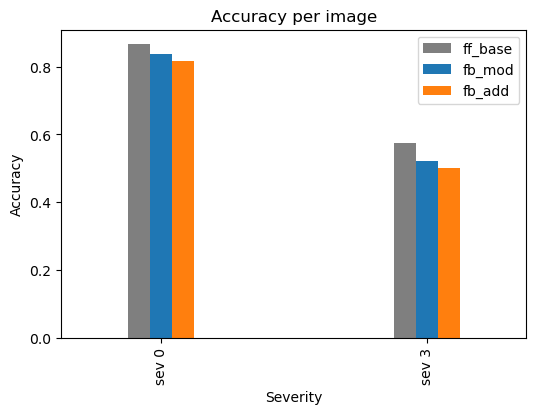

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

data = {'ff_base': [0.8663, 0.1107, 0.5736, 0.0532],
        'fb_mod': [0.8368, 0.2151, 0.522, 0.1205],
        'fb_add': [0.8158, 0.249, 0.4997, 0.0993]}

df = pd.DataFrame(data, index=['sev 0', '0 (FP)', 'sev 3', '3 (FP)'])
# only sev 0 and sev 3
df = df.loc[df.index.isin(['sev 0', 'sev 3'])]
# df = df.loc[df.index.isin(['0 (FP)', '3 (FP)'])]

df.plot(kind='bar', color=['tab:gray', 'tab:blue', 'tab:orange'], width=0.25, figsize=(6,4))

plt.title('Accuracy per image')
# plt.title('Accuracy per image (including FP)')
plt.xlabel('Severity')
plt.ylabel('Accuracy')
# plt.ylim([0, 0.6])

plt.show()

-----------
format original TP-FP list:

| 15  |  5   |  20 | 2 | 4952 | n |
|---|---|---|---|-|-|
|corruptions |severities | classes | tp, fp | images |detections|

-----------
format output of detections / ground truth:

| 4952  |  20    |    n     |   5   |
|---|---|---|---|
|images |classes | detected bboxes | bbox + certainty |
----------
### Results Robustness Benchmark
| model | mAP |  mPC   |  rPC |
|---|--|---|---|
|FF-Baseline | 0.801 | 0.489 | 60,5 % |
|FB-Mod | 0.806 | 0.468 | 57,5 % |
|FB-Add | 0.803 | 0.457 | 56,3 % |

[mAP] Performance on Clean Data in AP50  
[mPC] Mean Performance under Corruption in AP50  
[rPC] Relative Performance under Corruption in %  

### mAP per Severity
| |ff_base  |fb_mod |fb_add|
|-|---      |--     |   --|
|0|	0.801	|0.806	|0.803|
|1|	0.677	|0.668	|0.659|
|2|	0.594	|0.579	|0.570|
|3|	0.500	|0.477	|0.464|
|4|	0.384	|0.353	|0.340|
|5|	0.288	|0.263	|0.251|
--------

mPC calculation

    mPC = np.mean(results[:15, 1:, :], axis=(0, 1))
-> mean of 1500 APs
| 15  |  5   |  20 | =1500 |
|---|---|---|--|
|corruptions |severities | classes | = total nr.|

In [ ]:
""" 20 classes of PASCAL VOC
 0: aeroplane
 1: bicycle
 2: bird
 3: boat
 4: bottle
 5: bus
 6: car
 7: cat
 8: chair
 9: cow
10: diningtable
11: dog
12: horse
13: motorbike
14: person
15: pottedplant
16: sheep
17: sofa
18: train
19: tvmonitor
"""